<a href="https://colab.research.google.com/github/a8478836/AI-Study/blob/master/CycleGAN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


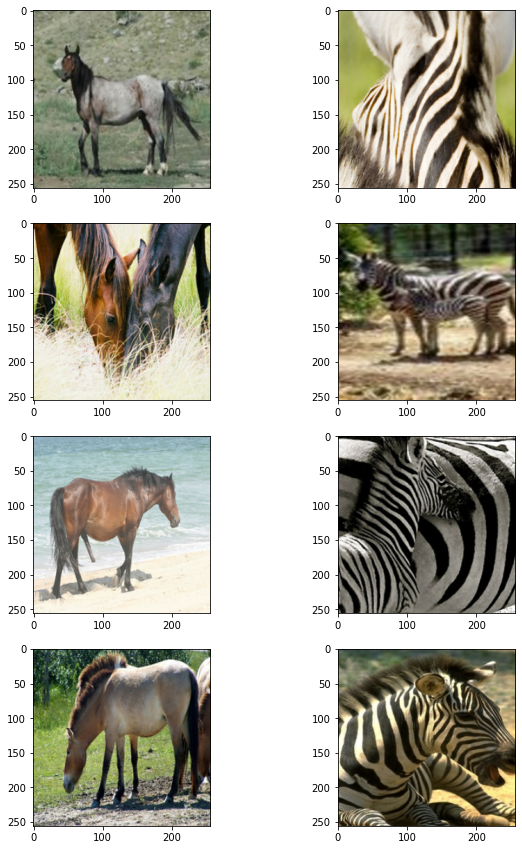

 115/1067 [==>...........................] - ETA: 11:42:06 - G_loss: 5.2331 - F_loss: 5.2927 - D_X_loss: 0.1527 - D_Y_loss: 0.1689

KeyboardInterrupt: ignored

In [11]:
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import sklearn

import tensorflow_addons as tfa
import tensorflow_datasets as tfds


# 데이터 적재, 전처리, 배치 하는 과정을 TF가 알아서 수행하도록
autotune = tf.data.AUTOTUNE

dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info = True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

# 평균 이미지 크기
orig_img_size = (286, 286)
# input image size, 만약 이미지 사이즈가 다 다르다면 맞춰줄 필요가 있음, 그리고 RGB이기 때문에 3임
input_img_size = (256, 256, 3)

 # 각 레이어별 layer의 weight 초기화 --> 1. 초기화 방법에 따른 결과를 비교해보자.
kernel_init = keras.initializers.RandomNormal(stddev=0.02)
gamma_init = keras.initializers.RandomNormal(stddev=0.02)

buffer_size = 256
batch_size = 1

def normalize_img(img):
  # img의 데이터 타입을 변환
  img = tf.cast(img, dtype=tf.float32)
  # -1과 1사이의 값으로 변환
  return (img / 127.5 ) - 1.0

#data augementation
def preprocess_train_image(img, label):
  # 이미지 랜덤하게 좌우반전
  img = tf.image.random_flip_left_right(img)
  # 입력 이미지의 크기를 변경
  img = tf.image.resize(img, [*orig_img_size])
  # 이미지를 256x256으로 랜덤하게 잘라냄 이 때 크기는 256 256
  img = tf.image.random_crop(img, size=[*input_img_size])
  # 픽셀의 값들을 -1과 1 사이로 정규화
  img = normalize_img(img)

  return img

# 테스트 이미지는 이미지 크기만 변환
def preprocess_test_image(img, label):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

# 학습 데이터 전처리
# preprocess 에서 data augementation한 후 cache, shuffle, batch 하는 것을 확인할 수 있음 그리고 이것을 autotune객체를 통해 텐서플로우가 알아서 병렬적으로 조정하여 실행
train_horses = (
    train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# 테스트 데이터 전처리
test_horses = (
    test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_zebras = (
    test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# 몇몇 데이터 확인
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

#-------------------------------- Generator, Discriminator에서 사용할 블록을 생성---------------------------------------------#
#layers.Layer 클래스를 상속
class ReflectionPadding2D(tf.keras.layers.Layer):
  def __init__(self, padding=(1,1), **kwargs):
    self.padding = tuple(padding)
    #super에 인자를 주지 않으면 자동으로 현재 클래
    #super().__init__(**kwargs)와 같으며 layers.Layer 클래스의 __init__에 키워드인자가 있기 때문에 **kwargs를 넣어줌
    super(ReflectionPadding2D, self).__init__(**kwargs)


  def call(self, input_tensor, mask=None):
    padding_width, padding_height = self.padding
    #input tensor의 shape가 [batch_size, height, width, channel] 이기 때문에 height, width에만 self.padding 만큼 패딩을 추가한다는 뜻
    padding_tensor = [
        [0, 0],
        [padding_height, padding_height],
        [padding_width, padding_width],
        [0, 0],
    ]

    return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma_initializer=gamma_init, use_bias=False,):
  dim = x.shape[-1]
  input_tensor = x
  x = ReflectionPadding2D()(input_tensor)
  x = tf.keras.layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = activation(x)

  x = ReflectionPadding2D()(x)
  x = tf.keras.layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  x = tf.keras.layers.add([input_tensor, x])
  
  return x


# input의 크기가 output보다 큼
def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=False,):
  x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  if activation:
    x = activation(x)
  return x

# input의 크기가 output보다 작음
def upsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=False,):
  x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias,)(x)
  x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
  if activation:
    x = activation(x)
  return x

#---------------------------------Bulid the generator--------------------------------------------#
"""
Generator는 2개의 downsampling, 9개의 resudial, 2개의 upsampling block으로 이루어져 있다.
그리고 마지막 convolutional block은 tanh 활성화 함수 사용하고 size는 7

"""




#왜 resnet인지 확인해볼 필요가 있음
def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2, gamma_initializer=gamma_init, name=None,):
    img_input = tf.keras.layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = tf.keras.layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = tf.keras.layers.Activation("relu")(x)

    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=tf.keras.layers.Activation("relu"))

    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=tf.keras.layers.Activation("relu"))


    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=tf.keras.layers.Activation("relu"))


    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = tf.keras.layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = tf.keras.layers.Activation("tanh")(x)

    model = tf.keras.models.Model(img_input, x, name=name)
    return model


# discriminator는 64 -> 128 -> 256 -> 512 순으로 유닛이 많아짐
# 근데 왜 discriminator는 leakyRelu일까?
def get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
  img_input = tf.keras.layers.Input(shape=input_img_size, name=name + "_img_input")
  x = tf.keras.layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer,)(img_input)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  num_filters = filters
  
  for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=tf.keras.layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2),)
        else:
            x = downsample(x, filters=num_filters, activation=tf.keras.layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1),)

  x = tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

  model = tf.keras.models.Model(inputs=img_input, outputs=x, name=name)
  return model


# generator 2개인 이유는 G : X -> Y 와 F : Y -> X
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# discriminator 2개인 이유는 마찬가지로  G와 F에 대한 discriminator라서
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")
  

# tf.keras.Model을 상속
class CycleGan(tf.keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X, discriminator_Y, lambda_cycle=10.0, lambda_identity=0.5,):
      # super CycleGAN의 부모 클래스의 메소드들을 상속받음
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer, disc_Y_optimizer, gen_loss_fn, disc_loss_fn, ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
      #x는 말, y는 얼룩말
      real_x, real_y = batch_data

      with tf.GradientTape(persistent=True) as tape:
            # 진짜 말을 이용해 가짜 얼룩말을 만듦
            fake_y = self.gen_G(real_x, training=True)
            # 진짜 얼룩말로 가짜 말을 만듦
            fake_x = self.gen_F(real_y, training=True)

            
            # 가짜 얼룩말로 가짜 말을 만듦
            cycled_x = self.gen_F(fake_y, training=True)
            #가짜 말로 가짜 얼룩말을 만듦
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping을 통해 gradient vanishing 문제 해결
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss 변경해보기
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss 변경해보기
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
      grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
      grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
      disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
      disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

      # Update the weights of the generators
      self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
      )
      self.gen_F_optimizer.apply_gradients(
          zip(grads_F, self.gen_F.trainable_variables)
      )

        # Update the weights of the discriminators
      self.disc_X_optimizer.apply_gradients(
          zip(disc_X_grads, self.disc_X.trainable_variables)
      )
      self.disc_Y_optimizer.apply_gradients(
          zip(disc_Y_grads, self.disc_Y.trainable_variables)
      )

      return {
          "G_loss": total_loss_G,
          "F_loss": total_loss_F,
          "D_X_loss": disc_X_loss,
          "D_Y_loss": disc_Y_loss,
      }

# 각 epoch 마다 이미지를 생성하고 저장하기 위한 클래스
class GANMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_horses.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = tf.keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


# adversarial loss 계산 MSE말고 다른거로 바꿔보기
adv_loss_fn = tf.keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_horses, train_zebras)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)


In [4]:
!pip3 install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
